## Backtesting Value at Risk and Median Shortfall with Python

In [1]:
def value_at_risk(returns, confidence_level):
    """
    Compute the Value-at-Risk metric of returns at confidence_level
    :param returns: DataFrame
    :param confidence_level: float
    :return: float
    """

    # Calculate the highest return in the lowest quantile (based on confidence level)
    var = returns.quantile(q=confidence_level, interpolation="higher")
    return var

def median_shortfall(returns, confidence_level):
    """
    Compute the Median Shortfall metric of returns at confidence_level
    :param returns: DataFrame
    :param confidence_level: float
    :return: float
    """

    # Calculate the VaR of the returns
    var = value_at_risk(returns, confidence_level)

    # Find all returns in the worst quantile
    worst_returns = returns[returns.lt(var)]

    # Calculate median of all the worst returns
    median_shortfall = worst_returns.median()

    return median_shortfall

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")

# Credit risk
start = '2006-01-01'
end = '2009-01-01'

# List of assets
assets = ['^GSPC', 'BRK-B', 'AAPL']

# Downloading the data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
ret = data.pct_change(1).dropna()

display(ret.head())

[*********************100%***********************]  3 of 3 completed


,^GSPC,BRK-B,AAPL
Date,,,
2006-01-04,0.002944,0.000675,0.003673
2006-01-05,-0.007870,-0.002359,0.000016
2006-01-06,0.025813,0.003378,0.009399
2006-01-09,-0.003277,0.003030,0.003656
2006-01-10,0.063248,-0.003021,-0.000357


In [3]:
n = ret.shape[0]

Risk_hist = {}
for i in assets:
    Risk_hist[i] = {'VaR':[], 'MS':[]}

window = 250 
confidence_level = 0.01

for j in assets:
    for i in range(window, n):
        X = ret[j].iloc[i-window:i]
        var_value = Risk_hist[j]['VaR'].append(value_at_risk(X, confidence_level))
        ms_value = Risk_hist[j]['MS'].append(median_shortfall(X, confidence_level))
        
        if var_value is not None and ret[j].iloc[i] < var_value:
            Risk_hist[j]['VaR_Exceptions'] += 1
        
        if ms_value is not None and ret[j].iloc[i] < ms_value:
            Risk_hist[j]['MS_Exceptions'] += 1
            
for i in assets:
    Risk_hist[i] = pd.DataFrame(Risk_hist[i], index=ret.index[window:])

[]

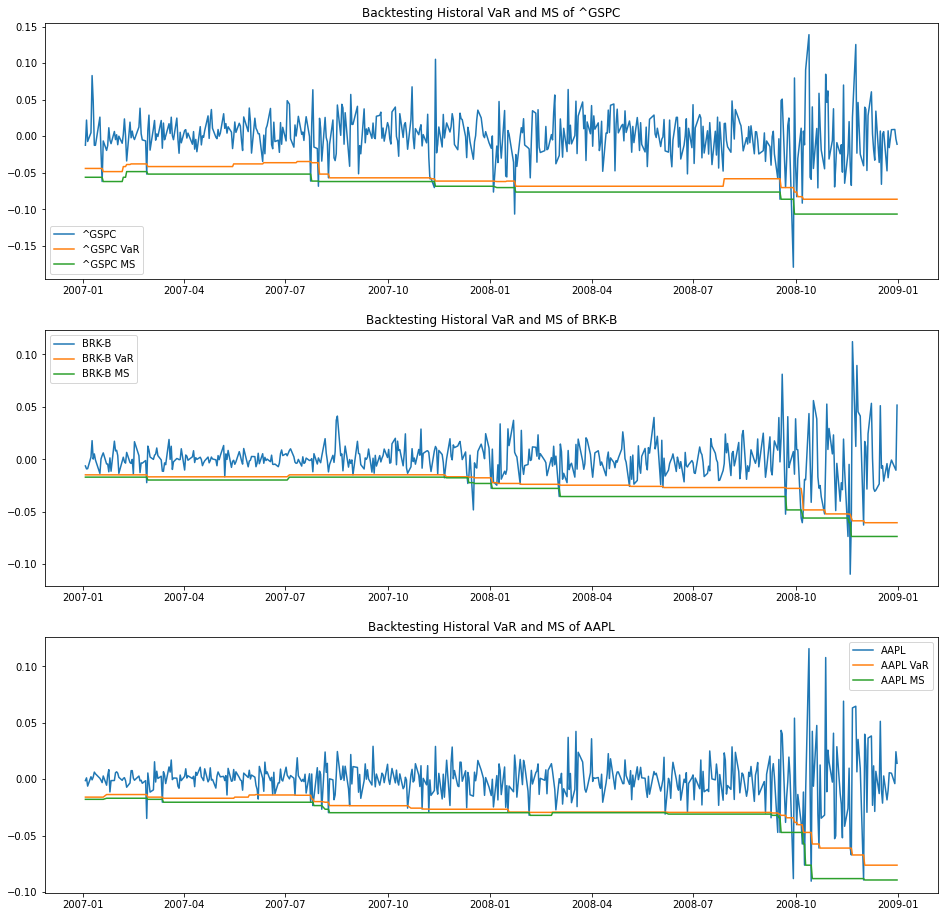

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(assets),1,figsize=(16, 16))

for i in range(len(assets)):
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    ax[i].plot(Risk_hist[assets[i]]['VaR'], label=assets[i] + ' VaR')
    ax[i].plot(Risk_hist[assets[i]]['MS'], label=assets[i] + ' MS')
    ax[i].legend()
    ax[i].set_title('Backtesting Historal VaR and MS of ' + assets[i])

plt.plot()

In [5]:
for i in range(len(assets)):
    varexceptions = (ret[assets[i]].iloc[window:] < Risk_hist[assets[i]]['VaR']).sum()
    msexceptions = (ret[assets[i]].iloc[window:] < Risk_hist[assets[i]]['MS']).sum()
    print(f"For {assets[i]}: Number of VaR Exceptions: {varexceptions}")
    print(f"For {assets[i]}: Number of MS Exceptions: {msexceptions}")


For ^GSPC: Number of VaR Exceptions: 13
For ^GSPC: Number of MS Exceptions: 9
For BRK-B: Number of VaR Exceptions: 18
For BRK-B: Number of MS Exceptions: 11
For AAPL: Number of VaR Exceptions: 29
For AAPL: Number of MS Exceptions: 15


In [6]:
def bern_test(p,v):
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    return (-2*(al-bl))

In [ ]:
keys = ['Failure Ratio VaR', 
        'Failure Ratio MS',
        'Bernoulli Test VaR stat',
        'Bernoulli Test VaR p-value',
        'Bernoulli Test MS stat',
        'Bernoulli Test MS p-value']

In [ ]:
Stats_hist = {}

for i in assets:
    Stats_hist[i] = {}
    for j in keys:
        Stats_hist[i][j] = []


In [ ]:
for i in Stats_hist.keys():
    for j in Risk_hist[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_hist[i][j],0)
        H = np.count_nonzero(a)
        T = Risk_hist[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(confidence_level, v)
        Stats_hist[i]['Failure Ratio ' + j].append(H/T)
        Stats_hist[i]['Bernoulli Test ' + j + 'stat'].append(round(ber, 5))
        Stats_hist[i]['Bernoulli Test ' + j + 'p-value'].append(round(1 - st.chi2.cdf(ber, 1),5))
        
a = pd.DataFrame([])        
for i in assets:
    Stats_hist[i] = pd.DataFrame(Stats_hist[i]).T
    Stats_hist[i].columns = [i]
    a = pd.concat([a, Stats_hist[i]], axis=1)

Stats_hist = a
display(Stats_hist)  